# Zadanie nr 6 - Wzorce dwuwymiarowe

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from time import time
from collections import deque
import cv2

W poniższej pracy słowo 'text' jest używane, aby określić strukturę dwuwymiarową, w której poszukujemy wzorców. Może to być np. lista pojedynczych linijek tekstu lub dwuwymiarowa tablica reprezentująca obrazek.

## 0. Funkcje pomocnicze

* funkcja wypisująca macierze 2D

In [2]:
def print2d(l): 
    print('\n'.join(map(''.join, list(map(lambda x: str(x).replace("'", ""), l)))), '\n')

* funkcja do wizualizacji grafu (korzystająca z biblioteki networkx)

In [3]:
def show_graph(head):
    graph = nx.DiGraph()
    
    stack = [head]
    visited = set()

    while stack:
        node = stack.pop()
        for key, edge_node in node.edges.items():
            graph.add_edge(node, edge_node, label=key)

            if edge_node not in visited and edge_node not in stack:
                stack.append(edge_node)

        if node.fail_link:
            graph.add_edge(node, node.fail_link)

        visited.add(node)
    
    plt.figure(figsize=(12, 7))
    
    pos = nx.spectral_layout(graph)
    nx.draw_networkx(graph, pos, connectionstyle='arc3, rad = 0.15', node_color='turquoise')
    labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()

* funkcja wyszukiwania wzorca w 1D z laboratorium nr 1

Do znajdowania wzorca w jednym wymiarze wykorzystuję algorytm KMP, którego złożoność obliczeniowa to: <br>
O(|wzorzec| + |tekst|)

In [4]:
def kmp(text, pattern):
    result = []

    pi = prefix_function(pattern)
    q = 0

    for i in range(0, len(text)):
        while q > 0 and pattern[q] != text[i]:
            q = pi[q-1]

        if pattern[q] == text[i]:
            q += 1

        if q == len(pattern):
            result.append(i + 1 - q)
            q = pi[q-1]

    return result


def prefix_function(pattern):
    pi = [0]
    k = 0

    for q in range(1, len(pattern)):
        while(k > 0 and pattern[k] != pattern[q]):
            k = pi[k-1]

        if(pattern[k] == pattern[q]):
            k = k + 1

        pi.append(k)

    return pi

## 1. Algorytm

Elementarne testy kolejnych kroków algorytmu przeprowadzam dla następującego wzorca i tekstu:

In [5]:
pattern = ['abc', 'aab', 'cba']
text= ['bcdef', 'aabcg', 'aaabh', 'ccbai', 'aabbb', 'abccb']
print('--pattern--')
print2d(pattern)

print('--text--')
print2d(text)

--pattern--
abc
aab
cba 

--text--
bcdef
aabcg
aaabh
ccbai
aabbb
abccb 



<i>1. Zaimplementuj algorytm wyszukiwania wzorca 2-wymiarowego </i>

Poniżej implementuję algorytm Aho-Corasick w wersji z automatem deterministycznym.

* struktura węzła grafu

In [6]:
class Node:
    index = 0

    def __init__(self, parent=None, char=None):
        self.id = Node.index
        Node.index += 1
        
        self.edges = {}
        self.fail_link = None
        self.parent = parent # rodzic w drzewie Trie
        self.char = char # argument funkcji przejścia z self.parent do tego node'a
        
        self.pattern_end = None # numer wzorca, który kończy się w tym węźle

    def __str__(self):
        return str(self.id)

* budowa Trie z podanych wzorców

In [7]:
def build_trie(patterns):
    Node.index = 0
    head = Node()

    for i, pattern in enumerate(patterns):
        current_node = head
        for char in pattern:
            if char not in current_node.edges:
                current_node.edges[char] = Node(char=char, parent=current_node)
            current_node = current_node.edges[char]

        if current_node.pattern_end is None:
            current_node.pattern_end = i+1

    return head

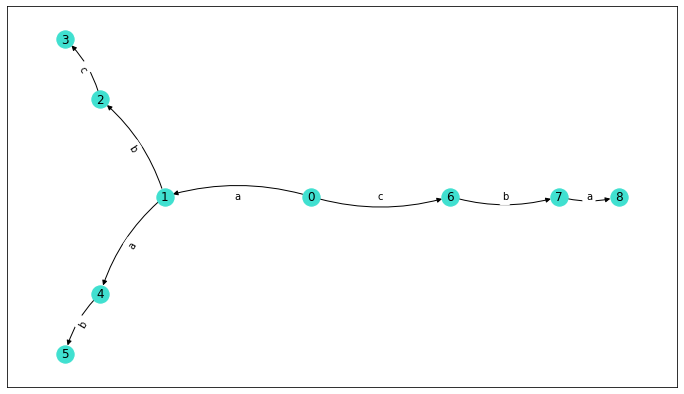

In [8]:
show_graph(build_trie(pattern))

* stworzenie podstawowej wersji automatu - dodanie fail linków do grafu

In [9]:
def build_automaton(patterns):
    head = build_trie(patterns)

    queue = deque([head])
    visited = set()

    def assign_fail_links(node):
        if node is not head:
            current_node = node.parent.fail_link
            while current_node:
                if node.char in current_node.edges:
                    node.fail_link = current_node.edges[node.char]
                    break
                current_node = current_node.fail_link
            else:
                node.fail_link = head

        for edge in node.edges.values():
            if edge not in visited and edge not in queue:
                queue.append(edge)

        visited.add(node)

    while queue:
        node = queue.popleft()
        assign_fail_links(node)

    return head

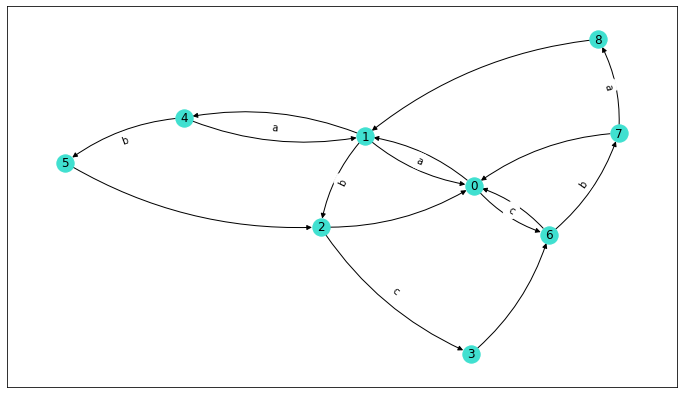

In [10]:
show_graph(build_automaton(pattern))

Powyższy graf jest prawie identyczny z tym, który został pokazany na laboratorium. (Krawędzie bez etykiet to fail linki). Jedyna różnica jest taka, iż węzeł nr 0 nie posiada krawędzi do samego siebie dla dowolnego symbolu. Nie jest ona jednak niezbędna i może zostać zastąpiona sprawdzaniem warunku w kodzie.

* modyfikacja automatu - usunięcie fail linków na rzecz zwiększenia liczby krawędzi

Poniższa funkcja dokonuje determinizacji automatu, w celu szybkiego i wygodnego przechodzenia pomiędzy stanami dla łańcucha wejściowego. Wiąże się jednak z niemałym narzutem pamięciowym, w zamian za pojedynczy fail link dodajemy do grafu często kilka nowych krawędzi.

In [11]:
def modify_automaton(head):
    queue = deque([head])
    visited = set()

    def copy_edges(node):
        if node is not head:
            for key, node_edge in node.fail_link.edges.items():
                if key not in node.edges:
                    node.edges[key] = node_edge

        for edge in node.edges.values():
            if edge not in visited and edge not in queue and edge is not node:
                queue.append(edge)

        visited.add(node)
        node.fail_link = None

    while queue:
        node = queue.popleft()
        copy_edges(node)

    return head

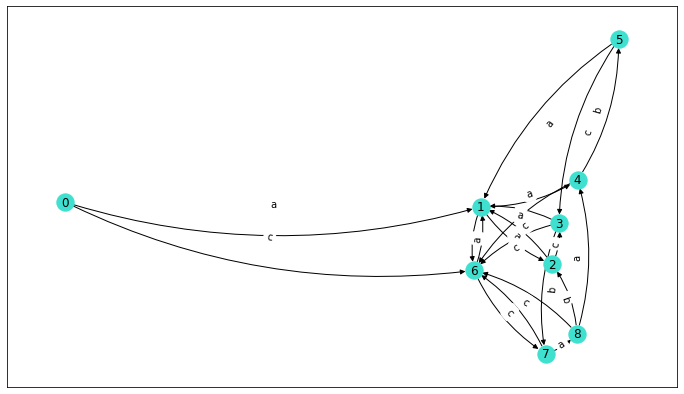

In [12]:
show_graph(modify_automaton(build_automaton(pattern)))

W wersji pokazanej na laboratorium oprócz powyższych krawędzi powinny istnieć także krawędzie od każdego węzła do wierzchołka 0 powiązane z dowolnym innym symbolem, który nie określa żadnej krawędzi z danego wierzchołka. Zamiast tego w kodzie sprawdzam czy istnieje przejście po zadanym znaku, a jeśli go nie ma to wracam do węzła nr 0.

* funkcja znajdująca wszystkie wystąpienia wzorca dwuwymiarowego w strukturze 2D

In [13]:
def pattern_match_2d(text, pattern, printing=False, measure_times=False):
    if measure_times: start = time()
        
    # przyporządkowanie wzorcowi 2d wektora z indeksami jego wierszy
    # gdyby wiersze się nie powtarzały, to byłby to wektor
    # kolejnych liczb naturalnych zaczynając od 1 i kończąc wymiarem 'height'
    # jeśli przykładowo wiersz z indeksem 1 będzie identyczny temu z indeksem 0,
    # to będą one miały równy indeks ([1, 1, ...])
    col_pattern = [-1 for _ in range(len(pattern))]
    i = 1
    for j, line in enumerate(pattern):
        if col_pattern[j] != -1: continue
        for k in range(j, len(pattern)):
            if pattern[k] == line:
                col_pattern[k] = i
                
        i += 1
    if printing: print('col_pattern: \n', col_pattern, '\n')
    
    # wybieram z wierszy wzorca tylko te unikatowe
    reduced_pattern = []
    for i, line in enumerate(pattern):
        if line not in reduced_pattern:
            reduced_pattern.append(line)  
    pattern = reduced_pattern
    
    # budowa automatu
    head = build_automaton(pattern)
    head = modify_automaton(head)
    
    if measure_times: 
        build_time = time() - start
        start = time()
    
    height = len(text)
    # linijki mogą mieć różną długość, więc wyznaczam width jako max,
    # po zastosowaniu algorytmu dla wierszy w nadmiarowym polach 
    # zostaną wartości 0, które nie należą nigdy do col_pattern 
    width = len(max(text, key=len)) 
    
    
    # macierz, w której w komórce [i][j] zapisujemy indeks wiersza wzorca
    # który kończy się na tych indeksach w strukturze text
    patterns_matrix = [[0 for _ in range(width)]
                       for _ in range(height)]
    
    # dopasowanie wielu wzorców dla wierszy
    # z wykorzystaniem automatu algorytmu Aho-Corasick
    for i, line in enumerate(text):
        current_node = head
        for j, char in enumerate(line):
            current_node = current_node.edges.get(char, head) 
            if current_node.pattern_end:
                patterns_matrix[i][j] = current_node.pattern_end
    
    if printing: 
        print('patterns_matrix:')
        print2d(patterns_matrix)
    
    result = []
    
    # dopasowanie wzorca col_pattern do wszystkich kolumn
    # macierzy patterns_matrix
    for i in range(width):
        line = [patterns_matrix[j][i] for j in range(height)]
        for j in kmp(line, col_pattern):
            result.append((j, i-len(pattern[0])+1)) ## zapisujemy lewy górny róg
            
    if printing: print('result:\n', result)
        
    if measure_times:
        search_time = time()-start
        return result, build_time, search_time
        
    return result

In [14]:
print('--pattern--')
print2d(pattern)

print('--text--')
print2d(text)

pattern_match_2d(text, pattern, printing=True)

--pattern--
abc
aab
cba 

--text--
bcdef
aabcg
aaabh
ccbai
aabbb
abccb 

col_pattern: 
 [1, 2, 3] 

patterns_matrix:
[0, 0, 0, 0, 0]
[0, 0, 2, 1, 0]
[0, 0, 0, 2, 0]
[0, 0, 0, 3, 0]
[0, 0, 2, 0, 0]
[0, 0, 1, 0, 0] 

result:
 [(1, 1)]


[(1, 1)]

Powyższa funkcja poprawnie odnalazła położenie górnego lewego rogu wzorca pattern w strukturze text.

## 2. Testy

<i>2. Znajdź w załączonym pliku "haystack.txt" wszystkie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach. Zwróć uwagę, na nierówną długość linii w pliku.</i>

* wczytanie tekstu z pliku i ustalenie alfabetu

In [15]:
with open('haystack.txt', 'r') as f:
    text_stack = [line.strip() for line in f]

alphabet = set(char for line in text_stack for char in line if char.isalpha())
print('letters:', alphabet)

letters: {'W', 'P', 'i', 'h', 'a', 'f', 'z', 'Q', 'd', 'T', 'v', 'X', 'F', 'u', 'B', 'U', 'V', 'e', 'n', 'l', 'k', 'E', 'y', 'm', 'p', 'N', 'G', 'O', 'j', 'M', 'b', 'g', 'q', 'L', 'x', 'I', 'r', 'C', 'A', 'S', 'D', 'o', 't', 's', 'R', 'c', 'w'}


* wyszukanie wzorca dla każdej litery z alfabetu

In [16]:
sum_ = 0
for char in alphabet:
    count = len(pattern_match_2d(text_stack, [[char], [char]]))
    if count > 0:
        print(f'{char}: {count}')
        sum_ += count
    
print('any letter: ', sum_)

i: 13
h: 4
a: 28
f: 2
d: 1
e: 48
n: 15
l: 5
y: 1
m: 5
p: 2
x: 1
r: 21
o: 21
t: 41
s: 19
c: 6
w: 2
any letter:  235


<i>3. Znajdź wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji.</i>

In [17]:
found = pattern_match_2d(text_stack, ["th", "th"])
print(f'th: found: {found}, count: {len(found)}')

th: found: [], count: 0


In [18]:
found = pattern_match_2d(text_stack, ["t h", "t h"])
print(f'th: found: {found}, count: {len(found)}')

th: found: [(37, 0)], count: 1


In [19]:
print2d(text_stack[found[0][0]:found[0][0]+2])

t h a t if inflected forms are considered. In French, inflected forms produce more
t h a n 700,000 words. T h e representation of lexicons of this size makes the 



Linijki o numerach 37 i 38 zaczynają się od symboli t h, algorytm odnalazł to wystąpienie.

<i>4. Wybierz przynajmniej 3 litery (małe). Znajdź wszystkie wystąpienia tej litery w załączonym pliku "haystack.png"</i>

Pomocnicza funkcja, zliczająca wystąpienia zadanej litery w tekście:

In [20]:
def count_letters(text, letter):
    return sum(1 for line in text_stack for char in line if char == letter)

Obrazek jest wczytywany w postaci trójwymiarowej tablicy numpy. Trzeci wymiar bierze się z tego, iż każdy piksel obrazka jest reprezentowany w formacie [r, g, b]. Aby bez komplikacji wykorzystać zaimplementowane wcześniej funkcje, rzutuję tę strukturę na dwuwymiarową listę o elementach będących krotkami (r, g, b). W ten sposób możemy porównywać listy bez wykorzystywania np.all/any. Jak również elementy w tablicy są hashowalne i mogą stanowić klucz dla słownika edge.

In [21]:
def to_list(array):
    n, m, p = array.shape
    array = array.tolist()
    for i in range(n):
        for j in range(m):
            array[i][j] = tuple(array[i][j])
    return array

In [22]:
image = cv2.imread('haystack.png')

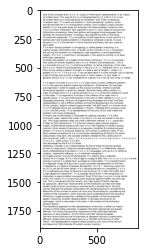

In [23]:
plt.imshow(image)

In [24]:
def find_letter(upper_left, lower_right, letter):
    letter_image = image[upper_left[0]:lower_right[0], upper_left[1]:lower_right[1]]
    plt.imshow(letter_image)
    plt.show()
    print('found on the image:\t', len(found := pattern_match_2d(to_list(image), to_list(letter_image))))
    print('found in the text:\t', len(found_text:=pattern_match_2d(text_stack, [[letter]])))
    print('actual letter count:\t', count_letters(text_stack, letter))
    print('cut letter in the list of found letters? ', upper_left in found)

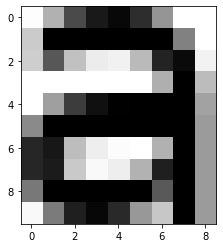

found on the image:	 397
found in the text:	 397
actual letter count:	 397
cut letter in the list of found letters?  True


In [25]:
find_letter((125, 274), (135, 283), 'a')

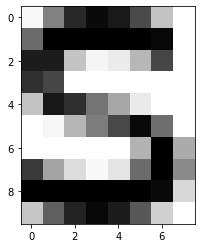

found on the image:	 334
found in the text:	 334
actual letter count:	 334
cut letter in the list of found letters?  True


In [26]:
find_letter((103, 31), (113, 39), 's')

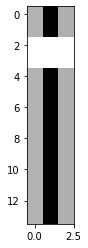

found on the image:	 343
found in the text:	 352
actual letter count:	 352
cut letter in the list of found letters?  True


In [27]:
find_letter((825, 724), (839, 727), 'i')

W przypadku litery 'i', na obrazku nie zostały odnalezione wszystkie wystąpienia. Wynika to najpewniej z faktu, iż niektóre z liter 'i' na obrazku różnią się od pozostałych wartością któregoś piksela. Funkcja sprawdza ścisłą tożsamość wzorców, drobny błąd w reprezentacji obrazka uniemożliwia zidentyfikowanie litery.

Mimo tego faktu, wszystkie litery 'a' oraz 's', a także dominująca liczba liter 'i' zostało odnalezionych.

<i>5. Znajdź wszystkie wystąpienia słowa "p a t t e r n" w haystack.png.</i>

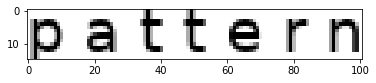

In [28]:
pattern_image = image[540:555, 241:342]
plt.imshow(pattern_image)

In [29]:
print('found on the image:\t', len(found := pattern_match_2d(to_list(image), to_list(pattern_image))))
print('found in the text:\t', len(pattern_match_2d(text_stack, ['p a t t e r n'])))
print('cut pattern in list of found letters? ', (540, 241) in found)

found on the image:	 5
found in the text:	 5
cut pattern in list of found letters?  True


## 3. Porównanie czasów

<i>6. Porównaj czas budowania automatu i czas wyszukiwania dla różnych rozmiarów wzorca</i>

Testy przeprowadzam dla obrazka haystack.png. Wyszukuję wycięty z niego wzorzec o wymiarach n x n, gdzie n zmienia się liniowo od 50 do szerokości obrazka. Zapisuję czasy budowy automatu (wraz z operacjami wyboru unikalnych wierszy i dobieraniem indeksów) oraz osobno czas samego wyszukiwania z gotowym już automatem.

In [30]:
def compare_times():
    build_times = []
    search_times = []
    max_n = min(image.shape[:2])
    ns = list(range(50, max_n, 50))
    
    for n in ns:
        pattern = to_list(image[:n, :n, :])
        _, build_time, search_time = pattern_match_2d(to_list(image), pattern, measure_times=True)
        build_times.append(build_time)
        search_times.append(search_time)
        
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].plot(ns, build_times, label='building', color='darkgreen')
    ax[0].plot(ns, search_times, label='searching', color='rosybrown')
    ax[0].legend()
    ax[0].set_xlabel('n')
    ax[0].set_ylabel('time (s)')
    
    ax[1].plot(ns, build_times, label='building', color='darkgreen')
    ax[2].plot(ns, search_times, label='searching', color='rosybrown')

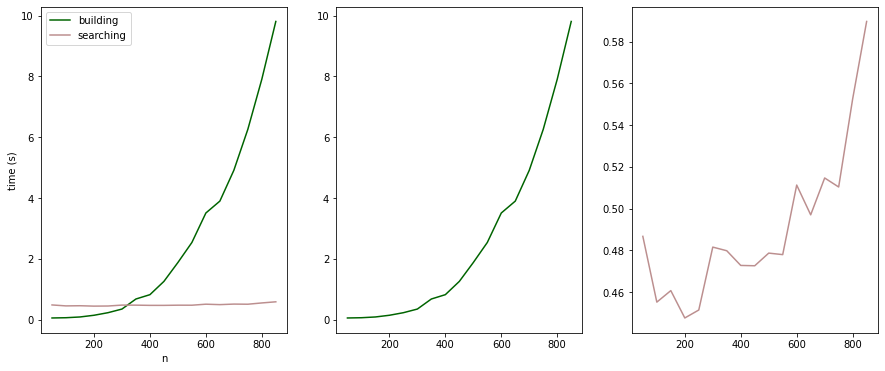

In [31]:
compare_times()

Czas potrzebny do stworzenia wzorca ma złożoność proporcjonalną do iloczynu wymiarów tego wzorca, co możemy zaobserwować na wykresie, który przypomina wykres funkcji O(n^2). Czas wyszukiwania jest natomiast zależny w głównej mierze od wielkości tekstu/struktury. Dla wszystkich testów struktura, w której poszukiwany był wzorzec była taka sama, dlatego czas jest mniej więcej stały.

W przypadku, w którym wzorzec miał rozmiary podobne do tekstu, czas budowy automatu był widocznie większy niż wyszukiwania. Mimo tego samego rzędu złożoności obydwu etapów, algorytm budowy automatu ma większą stałą, co łączy się z faktem bardziej skomplikowanej procedury z większą liczbą operacji elementarnych w każdym kroku.

<i>7. Podziel plik na 2, 4 i 8 fragmentów (w poziomie) i porównaj czas przeszukiwania</i>

In [32]:
def divide_and_match(text, pattern):
    search_times = []
    ns = [1, 2, 4, 8]
    
    for n in ns:
        search_time = 0
        
        for i in range(n):
            from_ = int(i/n*len(text))
            to = int((i+1)/n*len(text)) if i != n-1 else -1
            text_part = text[from_:to, :, :]
            _, _, s_t = pattern_match_2d(to_list(text_part), to_list(pattern), measure_times=True)
            search_time += s_t
        
        print(f'n: {n}, search time: {search_time}')
        search_times.append(search_time)
        
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(ns, search_times, marker='o', label='searching', color='rosybrown')
    ax.set_xlabel('n')
    ax.set_ylabel('time (s)')
    ax.legend()

n: 1, search time: 0.5002119541168213
n: 2, search time: 0.4827282428741455
n: 4, search time: 0.49007248878479004
n: 8, search time: 0.4944784641265869


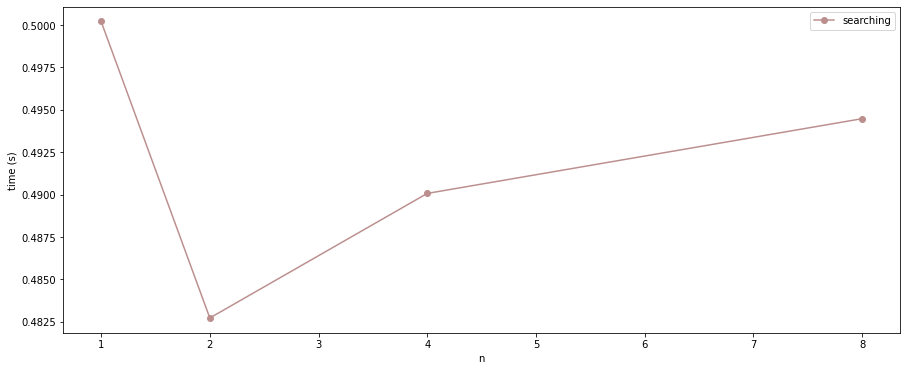

In [33]:
divide_and_match(image, image[:50, :50, :])

Nie zaobserwowałem poprawy szybkości działania algorytmu dzieląc tekst na kilka części. Suma powierzchni obrazka pozostała taka sama, a stąd łączny czas wyszukiwania we wszystkich częściach jest porównywalny dla każdej liczby n. Dodatkowo, jeśli wzorzec znajdowałby się jednocześnie w dwóch częściach (tzn. na ich granicy), to nie zostanie on odnaleziony.

## Wnioski

- Algorytm Aho-Corasick pozwala na równoczesne odnalezienie kilku wzorców w tekście.
- Jesteśmy w stanie dopasować dwuwymiarowy wzorzec w czasie proporcjonalnym do rozmiaru problemu (kwadratowym, bo zagadnienie jest w 2D).

M. Hawryluk 04.06.2021